In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import smallgraph as sg
import networkx as nx
from matplotlib import pyplot as plt
import lmz
import eden.graph as eg
import eden.display as ed
from yoda.graphs import ali2graph
import numpy as np
import yoda.ml.simpleMl as sml
import eden.display as ed
from yoda.alignments import load_rfam, filter_by_seqcount

In [2]:
a,l, te = sg.makedata()

no file:  cname='/home/ikea/rfam/test2/RF00001_5S_rRNA.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00003_U1.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00004_U2.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00005_tRNA.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00007_U12.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00008_Hammerhead_3.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00009_RNaseP_nuc.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00010_RNaseP_bact_a.sorted.cov', no problem there is just nothing covariing
no file:  cname='/home/ikea/rfam/test2/RF00011_RNaseP_bact_b.sorted.cov', no problem there is just nothing covariin

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 394/394 [00:00<00:00, 224532.03it/s]


In [3]:
# g =  ali2graph.nearstem( graphs[13].copy(), boost_range = 2, boost_thresh = .5, boost_weight = 100)
# ed.draw_graph(g, vertex_color='weight')

In [4]:
graphs = lmz.Map(ali2graph.writecons, a)
graphs = lmz.Map(ali2graph.dillute, graphs, dilute1 = .7, dilute2 = .4, fix_edges = True)
graphs = lmz.Map(ali2graph.set_weight, graphs, 
                 consThresh= .97 )
#graphs = lmz.Map(ali2graph.donest, graphs)
# graphs = lmz.Map(ali2graph.nearstem, graphs, boost_range = 3, boost_thresh = .5, boost_weight = 1)

matrix = eg.vectorize(graphs, normalization=True, min_r = 2,min_d=1, inner_normalization=True)
sml.knn_accuracy(matrix,l)

0.483271375464684

csls
dissimlocal
localscaling
mutualproximity
no
(269, 1) (269, 269)


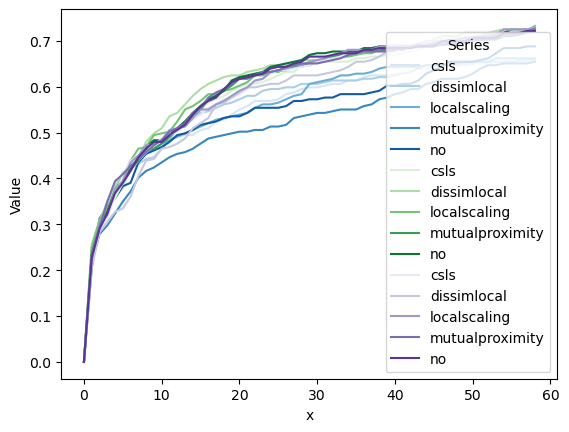

In [41]:
from kiez import Kiez 
import pandas as pd
import numpy as np
import seaborn as sns
if True:
    r= []
    kiezmeth = ['csls', 'dissimlocal', 'localscaling', 'mutualproximity', 'no']
    l=np.array(l)
    data = np.array(matrix.todense())
    for hub in kiezmeth:
        k_inst = Kiez(algorithm='SklearnNN', hubness=hub, n_candidates = 60)
        print(hub)
        k_inst.fit(data)
        neigh_dist, neigh_ind = k_inst.kneighbors()
        accs = sml.accs(neigh_ind,l)
        r.append(accs)
        
    df = pd.DataFrame(r).T  # Transpose to get the right shape
    df.columns = kiezmeth
    df['x'] = np.arange(df.shape[0])
    df_melted = df.melt(id_vars='x', var_name='Series', value_name='Value')
    sns.lineplot(data=df_melted, x='x', y='Value', hue='Series', palette='Blues')
    #plt.show()
    r= []
    l=np.array(l)
    from sklearn.preprocessing import normalize
    from sklearn.metrics import euclidean_distances
    data = euclidean_distances(data)
    data = normalize(data, axis=0)
    for hub in kiezmeth:
        # we require to edit kiez to accept precomputed as a valid metric
        k_inst = Kiez(algorithm='SklearnNN', hubness=hub, n_candidates = 60, algorithm_kwargs= {'metric' : 'precomputed'})
        k_inst.fit(data)
        neigh_dist, neigh_ind = k_inst.kneighbors()
        accs = sml.accs(neigh_ind,l)
        r.append(accs)
        
    df = pd.DataFrame(r).T  # Transpose to get the right shape
    df.columns = kiezmeth
    df['x'] = np.arange(df.shape[0])
    df_melted = df.melt(id_vars='x', var_name='Series', value_name='Value')
    sns.lineplot(data=df_melted, x='x', y='Value', hue='Series',palette='Greens')




    from sklearn.preprocessing import StandardScaler
    data = np.array(matrix.todense())
    data = euclidean_distances(data)
    scaler = StandardScaler()
    data2 = scaler.fit_transform(data)

    row_mins = data2.min(axis=1)[:,np.newaxis]
    
    # Step 2: Add the minimum value of each row to each element in that row
    # We need to reshape row_mins to a column vector for broadcasting
    print(row_mins.shape, data2.shape)
    data = data2 - row_mins

    
    r= []
    for hub in kiezmeth:
        #k_inst = Kiez(algorithm='SklearnNN', hubness=hub, n_candidates = 60)
        k_inst = Kiez(algorithm='SklearnNN', hubness=hub, n_candidates = 60, algorithm_kwargs= {'metric' : 'precomputed'})
        k_inst.fit(data)
        neigh_dist, neigh_ind = k_inst.kneighbors()
        accs = sml.accs(neigh_ind,l)
        r.append(accs)
        
    df = pd.DataFrame(r).T  # Transpose to get the right shape
    df.columns = kiezmeth
    df['x'] = np.arange(df.shape[0])
    df_melted = df.melt(id_vars='x', var_name='Series', value_name='Value')
    sns.lineplot(data=df_melted, x='x', y='Value', hue='Series', palette='Purples')

In [6]:
from ubergauss import optimization as op
import yoda.ml.simpleMl as sml

manyseq, fewseq = filter_by_seqcount(a)

def eval(ali,labels,
         ct = .95, 
         RYthresh = 0,
         norm = True, 
         d1 = .7,
         d2= .4,
         bad_weight = 0.1,
         fix_edges = True,
         # boost_range = 3, boost_thresh = .5, boost_weight = 1,
         min_r = 2, 
         nest = True,
         min_d = 1,**nothingtosee):
    
    graphs = lmz.Map(ali2graph.set_weight_label, ali, RYthresh=RYthresh)
    graphs = lmz.Map(ali2graph.dillute, graphs, dilute1 = d1, dilute2 = d2, fix_edges = fix_edges )
    graphs = lmz.Map(ali2graph.set_weight, graphs,  bad_weight = bad_weight,  consThresh= ct )
    
    if nest:
        graphs = lmz.Map(ali2graph.donest, graphs)
    # graphs = lmz.Map(ali2graph.nearstem, graphs, boost_range = boost_range, boost_thresh = boost_thresh, boost_weight = boost_weight)
    # graphs = [a.graph for a in ali]
    
    
    # matrix = vectorize_graphs_hack(graphs,disthack = kernelhack, normalization=norm, min_r = min_r,min_d=min_d,r=r,d=d, inner_normalization=norm) #.toarray() 
    matrix = eg.vectorize(graphs, normalization=norm,
                      min_r = min_r,min_d=min_d,
                      inner_normalization=norm) #.toarray()
        
    # ret= sml.knn_accuracy(matrix,labels)
    ret = sml.knn_accuracy(matrix,labels)
    # matrix = matrix @ matrix.T
    #ret = sml.average_precision(-matrix,labels)
    ret = {'score': ret} # , 'score_many': sml.knn_accuracy(matrix,labels, select_labels = manyseq)}
    return ret


space = '''min_r 1 5 1
min_d 1 5 1
nest 0 1 1
fix_edges 0 1 1
ct .6 1
d1 0 1
d2 0 1
bad_weight 0 1'''

space = sg.string_to_space(space)

#z= op.gridsearch(eval, space , tasks = [space.sample() for i in range(20)] , data= [a,l], mp=True)

# eval(a,l,**{'min_d': 3, 'min_r': 4, 'nest': 1})

In [7]:
z

NameError: name 'z' is not defined

In [ ]:
import seaborn as sns
sns.pairplot(z, hue='score')
plt.show()
sg.uo.get_best(z)

In [ ]:
sg.uo.dfprint(z)

In [ ]:
z.corr()

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc
mod = rfc().fit(matrix, l)
pred = mod.predict(matrix)
from sklearn.metrics import accuracy_score
accuracy_score(l,pred)
ftscore = mod.feature_importances_

In [ ]:
import umap
e = umap.UMAP().fit_transform(matrix)
plt.scatter(*e.T,c=l, cmap='tab20')


In [ ]:
import yoda.ml.simpleMl as sml

def slowplot(X,y):
    z = np.unique(y)
    for g in lmz.Grouper(z,9):
        print(g)
        translate = {asd:i for i,asd in enumerate(g)}
        plt.scatter(*X.T, c= [ translate[l] if l in g else -1 for l in y  ], cmap = 'tab10')
        plt.show()
        plt.close()
slowplot(e,l)       

In [ ]:
import umap
from sklearn.decomposition import PCA
scr = ftscore[ftscore  > 0.00001]
mat = matrix.T[ftscore > 0.00001]
histomat = np.sort(mat, axis =0)
e = umap.UMAP(n_neighbors = 100).fit_transform(histomat)
# e = PCA(n_components=2).fit_transform(histomat)
plt.scatter(*e.T,c=scr)

In [ ]:
%%time
print(0)

In [ ]:
sml.knn_accuracy(m2,labels)

In [ ]:
lengths = [aa.alignment.shape[0] for aa in a]
z= [(aa.clusterlabel, aa.alignment.shape[0],i) for i,aa in enumerate(a)]
for v in sorted(z):
    print(v)

In [ ]:
ed.draw_graph(graphs[243], vertex_color = 'weight')
plt.show()
ed.draw_graph(graphs[226], vertex_color = 'weight')
plt.show()
ed.draw_graph(graphs[248], vertex_color = 'weight')
plt.show()

In [ ]:
my_array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# Define the value you want to search for
search_value = 4

# Use numpy.where() to get the indices where the condition is true
indices = np.where(my_array == search_value)[0]
indices

In [ ]:
a[7].alignment.shape

In [ ]:
histos = ali2graph.get_histograms(a[1]) 
histos += ali2graph.get_histograms(a[0]) 
histos += ali2graph.get_histograms(a[2]) 
histos += ali2graph.get_histograms(a[3]) 
histos += ali2graph.get_histograms(a[4]) 
histos += ali2graph.get_histograms(a[5]) 
histos += ali2graph.get_histograms(a[6]) 
histos += ali2graph.get_histograms(a[7]) 
import umap
from yoda import draw
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

histos = np.array(histos)
# histos = histos[:,:-1]
print(histos.shape)
y = GaussianMixture(n_components = 5, covariance_type='full').fit_predict(histos) # tied 
#y = KMeans(n_clusters = 6).fit_predict(histos) # tied 

y= np.argmax(histos, axis = 1)

In [ ]:
y[ histos[range(len(histos)),y] < .7 ] = 5

In [ ]:
data = umap.UMAP(n_neighbors = 50).fit_transform(histos)
draw.scatter(data,y)

In [ ]:
for yy in np.unique(y):
    print (yy)
    print(sum(yy==y)/len(y))
    print (np.mean(histos[yy==y], axis =0))

In [ ]:
plt.plot([GaussianMixture(n_components=x, covariance_type='full',n_init=1000).fit(histos).bic(histos) for x in range(1,10)])